How to use if you want to do the *INFERENCE*
- Download *checkpoints_baseline* from https://drive.google.com/drive/folders/1_13U4DmnYnTqc8FfvA7AL5pO5V5HDcTn. Make sure that the following path exists *"/informer_experiments/checkpoints_informer"*
- Clone the informer original repo (required step), navigate to the clonned repo
- Make sure that you coppied the dataset from the ```efficient-transformers-4seqdata/datasets``` to ```Informer2020/data```. You can use the ```cp``` command
- Run the code blocks sequentially up to *Training & Inference* section. You don't have to load models yourself, it is done automatically in the inference loops
- Run the inference part


If you want to train a model, just use the training section

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020

Cloning into 'Informer2020'...
remote: Enumerating objects: 573, done.
remote: Total 573 (delta 0), reused 0 (delta 0), pack-reused 573
Receiving objects: 100% (573/573), 6.48 MiB | 4.93 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [5]:
%cd Informer2020/
!cp ../../datasets/btc-usdt-1.csv data/

In [14]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [15]:
root_path = 'data//'
data_path = 'btc-usdt-1.csv'

df = pd.read_csv(os.path.join(root_path, data_path))
df['target'] = (df['bid_price'] + df['ask_price'])/2
df = df.drop(['exchange_time', 'instrument', 'bid_price', 'bid_size', 'ask_price', 'ask_size'], axis = 1)
df.columns = df.columns.str.replace('our_time', 'date')
df.to_csv('data_clean.csv',index = False, sep=',')

In [16]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'target' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 30  # input sequence length of Informer encoder
args.label_len = 15 # start token length of Informer decoder
args.pred_len = 5 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 1 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 256
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 1
args.patience = 1
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [17]:
args.root_path = '.'
args.data_path = 'data_clean.csv'

In [18]:
'''
set 'target'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

timeenc = 0 if args.embed!='timeF' else 1
flag = 'train'; shuffle_flag = True; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, 
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [19]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [20]:
args.data = 'custom'

# Training & Inference

# Training section (skipped)

In [3]:
#for ii in range(args.itr):
    # setting record of experiments
#    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
#                args.seq_len, args.label_len, args.pred_len,
#                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
 #   exp = Exp(args)
    
    # train
 #   print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
 #   exp.train(setting)

In [10]:
# torch.save(exp.state_dict(), './informer_checkpoint.pt')

# Inference

### Memory footprint

In [21]:
import gc
gc.collect(), torch.cuda.empty_cache()

(0, None)

In [14]:
print('warm up...')
args.seq_len = 15
args.label_len = int(args.seq_len / 2)
exp = Exp_Informer(args)
before_inference = torch.cuda.mem_get_info()[0]/1.049e+6
with torch.no_grad():
    exp.model.load_state_dict(torch.load(f'../checkpoints_informer/checkpoint_CL={15}.pth'))
    pred_data, pred_loader = exp._get_data(flag='test')
    batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(pred_loader))
    pred, true = exp._process_one_batch(pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
#print(f'- - - - Seq length {args.seq_len}, Memory used = {before_inference - after_inference}')
print('Memory footprint...')
gc.collect(), torch.cuda.empty_cache()
for CL in [15, 30, 60, 120, 240]:
    args.seq_len = CL
    args.label_len = int(args.seq_len / 2)
    exp = Exp_Informer(args)
    before_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    with torch.no_grad():
        exp.model.load_state_dict(torch.load(f'../checkpoints_informer/checkpoint_CL={CL}.pth'))
        pred_data, pred_loader = exp._get_data(flag='test')
        batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(pred_loader))
        pred, true = exp._process_one_batch(pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
    after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    print(f'- - - - Seq length {args.seq_len}, Memory used = {before_inference - after_inference}')
    gc.collect(), torch.cuda.empty_cache()


warm up...
Use GPU: cuda:0
test 17276
Memory footprint...
Use GPU: cuda:0
test 17276
- - - - Seq length 15, Memory used = 83.96604766444216
Use GPU: cuda:0
test 17276
- - - - Seq length 30, Memory used = 167.93209532888454
Use GPU: cuda:0
test 17276
- - - - Seq length 60, Memory used = 419.83023832221147
Use GPU: cuda:0
test 17276
- - - - Seq length 120, Memory used = 839.6604766444232
Use GPU: cuda:0
test 17276
- - - - Seq length 240, Memory used = 1772.5832430886558


### Inference speed

In [22]:
import time

In [23]:
import numpy as np

In [13]:
def benchmark(exp, pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark, dtype='fp32', nwarmup=50, nruns=1000, device='cuda', period=100):
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = exp._process_one_batch(pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            _ = exp._process_one_batch(pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%period==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*nruns))

    #print("Output features size:", features.size())

    print('Average batch time: %.2f ms'%(np.mean(timings)*nruns))

    return np.mean(timings)*nruns

In [17]:
import time

In [20]:
for CL in [15, 30, 60, 120, 240]:
    args.seq_len = CL
    args.label_len = int(args.seq_len / 2)
    print(f'current{args.seq_len}')
    exp = Exp_Informer(args)
    before_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    with torch.no_grad():
        exp.model.load_state_dict(torch.load(f'../checkpoints_informer/checkpoint_CL={CL}.pth'))
        pred_data, pred_loader = exp._get_data(flag='test')
        batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(pred_loader))
        benchmark(exp, pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
    after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    gc.collect(), torch.cuda.empty_cache()


current15
Use GPU: cuda:0
test 17276
Warm up ...
Start timing ...
Iteration 100/1000, ave batch time 90.32 ms
Iteration 200/1000, ave batch time 90.64 ms
Iteration 300/1000, ave batch time 91.58 ms
Iteration 400/1000, ave batch time 91.51 ms
Iteration 500/1000, ave batch time 91.38 ms
Iteration 600/1000, ave batch time 91.25 ms
Iteration 700/1000, ave batch time 91.49 ms
Iteration 800/1000, ave batch time 91.38 ms
Iteration 900/1000, ave batch time 91.60 ms
Iteration 1000/1000, ave batch time 91.78 ms
Average batch time: 91.78 ms
current30
Use GPU: cuda:0
test 17276
Warm up ...
Start timing ...
Iteration 100/1000, ave batch time 150.09 ms
Iteration 200/1000, ave batch time 150.13 ms
Iteration 300/1000, ave batch time 151.75 ms
Iteration 400/1000, ave batch time 151.78 ms
Iteration 500/1000, ave batch time 152.55 ms
Iteration 600/1000, ave batch time 152.25 ms
Iteration 700/1000, ave batch time 152.55 ms
Iteration 800/1000, ave batch time 152.76 ms
Iteration 900/1000, ave batch time 152

### Predictions quality

In [25]:
# test
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

# torch.cuda.empty_cache()

>>>>>>>testing : informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 17280
test shape: (17280, 1, 1, 1) (17280, 1, 1, 1)
test shape: (17280, 1, 1) (17280, 1, 1)
mse:7.218769073486328, mae:1.9692894220352173


In [26]:
print('after inference ||',  'free:', torch.cuda.mem_get_info()[0]/1.049e+6, 'total:', torch.cuda.mem_get_info()[1]/1.049e+6, '[in MiB]')
after_inference = torch.cuda.mem_get_info()[0]/1.049e+6

after inference || free: 13644.232846520496 total: 15103.642722592946 [in MiB]


In [28]:
import numpy as np
y_pred = np.load('/content/Informer2020/results/informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
y_true = np.load('/content/Informer2020/results/informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')

In [30]:
y_pred_1d = np.squeeze(y_pred)
y_true_1d = np.squeeze(y_true)

___

In [24]:
args.seq_len = 30
args.label_len = int(args.seq_len / 2)

In [54]:
!ls ../checkpoints_informer

'checkpoint_CL=240.pth'  'checkpoint_CL=30.pth'


In [55]:
exp = Exp_Informer(args)
with torch.no_grad():
    exp.model.load_state_dict(torch.load(f'../checkpoints_informer/checkpoint_CL={240}.pth'))
    pred_data, pred_loader = exp._get_data(flag='val')

Use GPU: cuda:0
val 8637


In [56]:
batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(pred_loader))

In [57]:
y_pred, y_true = exp._process_one_batch(pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)

In [ ]:
import joblib

scaler = joblib.load('scaler.save') 

In [58]:
y_pred_unscaled = scaler.inverse_transform(
    y_pred.detach().cpu().numpy().reshape(1, -1)
).squeeze()

In [59]:
y_true = scaler.inverse_transform(
    y_true.detach().cpu().numpy().reshape(1, -1)
).squeeze()

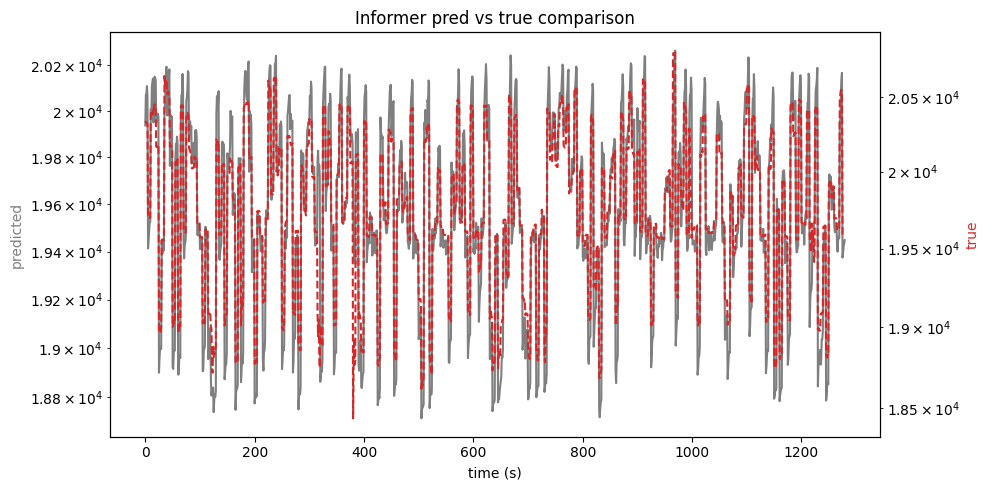

In [53]:
import matplotlib.pyplot as plt

_, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:gray'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('predicted', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(y_pred_unscaled, color=color)
ax1.set_yscale('log')

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('true', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(y_true, '--', color=color)
ax2.set_yscale('log')

plt.title('Informer pred vs true comparison')

plt.tight_layout()
plt.savefig('informer', dpi=1000)

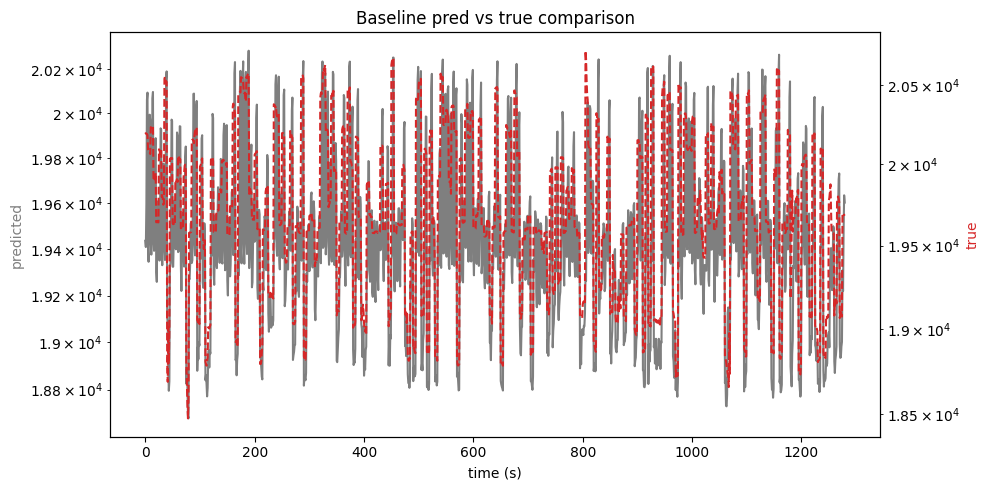

In [60]:
import matplotlib.pyplot as plt

_, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:gray'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('predicted', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(y_pred_unscaled, color=color)
ax1.set_yscale('log')

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('true', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(y_true, '--', color=color)
ax2.set_yscale('log')

plt.title('Baseline pred vs true comparison')

plt.tight_layout()
plt.savefig('informer', dpi=1000)